# Data Challenge 9 — Feature Engineering & Feature Selection

**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Engineer better predictors (one-hot/dummies, interactions, polynomials), avoid unnecessary complexity, and compare a **Base** vs **Engineered** model on the **same train–test split** using **MAE/RMSE**. Interpret coefficients in units and explain business value.



> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

**Docs (quick links):**
- One-hot encoding (pandas): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  
- OneHotEncoder (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
- Train/Test Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- MAE / MSE / RMSE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html  
- OLS (statsmodels): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (coef/p/CIs/resid): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

### Pseudocode Plan (Feature Engineering + Selection)
1) **Load CSV** → preview columns/shape.  
2) **Pick Y and initial Xs (2–3 numeric)** → keep it simple and decision-time-available.  
3) **Engineer features:**
   - **One-hot** a categorical with a dropped baseline (e.g., `payment_type` or `weekday/weekend`).  
   - **Interaction**: choose a hypothesis-driven pair (e.g., `trip_distance × is_weekend`).  
   - **Polynomial**: add one squared term for a plausible curve (e.g., `trip_distance²`).  
4) **Build Base vs Engineered design matrices** (add intercept).  
5) **Single train–test split** (80/20, fixed `random_state`) shared by both models.  
6) **Fit on TRAIN**, **predict on TEST** for both models; compute **MAE/RMSE** (units of Y).  
7) **Interpretation**: write unit-based coefficient sentences; note baseline category for dummies.  
8) **Light selection**: if Engineered model doesn’t beat Base on TEST (or adds complexity w/o value), prefer Base.  
9) **Diagnostics (quick)**: residuals vs fitted (train); note any cones (heteroskedasticity).  
10) **Stakeholder one-liner**: which model, why (TEST metrics in units), and what the added features *mean*.
markdown


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [109]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [110]:
df = pd.read_csv("/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/Yellow_Taxi_Data.csv", low_memory=False)

df = df.dropna()

df = df.apply(pd.to_numeric, errors='ignore')

(df.shape, df.columns.tolist())

/var/folders/cs/x0q13b6514sbl5vlbl495zxc0000gn/T/ipykernel_11390/2314027767.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


((3133527, 19),
 ['VendorID',
  'tpep_pickup_datetime',
  'tpep_dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'RatecodeID',
  'store_and_fwd_flag',
  'PULocationID',
  'DOLocationID',
  'payment_type',
  'fare_amount',
  'extra',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'improvement_surcharge',
  'total_amount',
  'congestion_surcharge',
  'airport_fee'])

### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [111]:
num_cols = ['fare_amount', 'trip_distance','tolls_amount','tip_amount']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
)
    

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
len(df)

3133527

In [112]:
df = df[(df['fare_amount'] > 0) & (df['trip_distance'] > 0) & (df['tolls_amount'] >= 0) & (df['tip_amount'] >= 0)]

df['payment_type'] = df['payment_type'].replace({0:"Flex_Fare",1:'Credit_Card',2:'Cash',3:'No_Charge',4:'Dispute'})

# lost about 110000 records
print(len(df))


x = df[['tip_amount','tolls_amount','payment_type','trip_distance']]
y = df['fare_amount']

3056238


### Step 3 —  Engineer New Features (One-hot, Interaction, Polynomial)

Pick **one** categorical to one-hot (drop baseline). Options that usually exist:

- `payment_type` (codes): treat as categorical strings for clarity, then one-hot with drop_first=True, or  
- derive **weekday/weekend** from `tpep_pickup_datetime` if present.

Then add **one interaction** and **one squared term** guided by a business hypothesis.

In [113]:
dummies_pd = pd.get_dummies(x['payment_type'], drop_first=True, prefix='payment')
x = pd.concat([x, dummies_pd], axis=1)
print("Data with pd.get_dummies")
print(x.head(5))

Data with pd.get_dummies
   tip_amount  tolls_amount payment_type  trip_distance  payment_Credit_Card  \
0      3.0000        0.0000  Credit_Card         0.6900                 True   
1      0.0000        0.0000         Cash         1.1000                False   
3      0.0000        0.0000      Dispute         1.5700                False   
4      3.0000        0.0000  Credit_Card         3.0000                 True   
6      0.0000        0.0000      Dispute         1.2400                False   

   payment_Dispute  payment_No_Charge  
0            False              False  
1            False              False  
3             True              False  
4            False              False  
6             True              False  


In [114]:
x.columns[x.columns.duplicated()].unique()
x = x.loc[:, ~x.columns.duplicated()]


In [115]:
x['above_average_tip'] = x['tip_amount'] > x['tip_amount'].quantile(0.5)
x['tripdistance_x_aat'] = x['trip_distance'] * x['above_average_tip']

x

,tip_amount,tolls_amount,payment_type,trip_distance,payment_Credit_Card,payment_Dispute,payment_No_Charge,above_average_tip,tripdistance_x_aat
0,3.0000,0.0000,Credit_Card,0.6900,True,False,False,True,0.6900
1,0.0000,0.0000,Cash,1.1000,False,False,False,False,0.0000
3,0.0000,0.0000,Dispute,1.5700,False,True,False,False,0.0000
4,3.0000,0.0000,Credit_Card,3.0000,True,False,False,True,3.0000
6,0.0000,0.0000,Dispute,1.2400,False,True,False,False,0.0000
...,...,...,...,...,...,...,...,...,...
3310901,0.0000,0.0000,Cash,0.7100,False,False,False,False,0.0000
3310902,2.3600,0.0000,Credit_Card,1.7000,True,False,False,False,0.0000
3310903,18.4600,6.9400,Credit_Card,21.6000,True,False,False,True,21.6000
3310905,17.5400,0.0000,Credit_Card,0.0100,True,False,False,True,0.0100


### Step 4 — Build **Base** and **Engineered** Design Matrices

- **Base** = intercept + base predictors (Xs you assigned in Step 2) 
- **Engineered** = intercept + base predictors + engineered columns (dummies + interaction + polynomial)


In [116]:
base_vars = ['tip_amount', 'tolls_amount', 'trip_distance']
base = sm.add_constant(x[base_vars])

eng_vars = [
    'tip_amount', 'tolls_amount', 'trip_distance',
    'payment_Credit_Card', 'payment_Dispute',
    'payment_No_Charge','payment_Flex_Fare','tripdistance_x_aat'
]

# Make sure all these columns exist
missing = [col for col in eng_vars if col not in x.columns]
if missing:
    print("⚠️ Missing columns:", missing)
else:
    engineered = sm.add_constant(x[eng_vars].copy())  # use .copy() to avoid view errors

    # Convert dummy variables to integer type safely
    engineered[['payment_Credit_Card', 'payment_Dispute', 'payment_Flex_Fare', 'payment_No_Charge']] = (
        engineered[['payment_Credit_Card', 'payment_Dispute', 'payment_Flex_Fare' ,'payment_No_Charge']].astype(int)
    )

    print("✅ Engineered design matrix ready:", engineered.shape)

⚠️ Missing columns: ['payment_Flex_Fare']


In [117]:
print(df.columns.tolist())


['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


### Step 5 — Single Train–Test Split (Shared by Both Models)

Use one split so Base and Engineered are comparable.

In [118]:
np.random.seed(9001)

b_x_train, b_x_test, b_y_train, b_y_test = train_test_split(base, y, test_size=0.2, random_state=9001)

eng_x_train, eng_x_test, eng_y_train, eng_y_test = train_test_split(engineered, y, test_size=0.2, random_state=9001)

### Step 6 — Fit on TRAIN, Predict on TEST, Compute **MAE/RMSE** (units of Y)

In [119]:
basemodel = sm.OLS(b_y_train, b_x_train).fit()

# --- Evaluate the model on the unseen testing data ---
basepredictions = basemodel.predict(b_x_test)

basemae = mean_absolute_error(b_y_test, basepredictions)
basermse = np.sqrt(mean_squared_error(b_y_test, basepredictions))

print(f"\nMean Absolute Error on Test Data: {basemae:.2f}")
print(f"Root Mean Squared Error on Test Data: {basermse:.2f}")
print(f"\nPredicting fare amounts on new data are off by an average of ${basemae*1000:,.2f}.")


Mean Absolute Error on Test Data: 7.56
Root Mean Squared Error on Test Data: 12.15

Predicting fare amounts on new data are off by an average of $7,555.46.


In [120]:
engineermodel = sm.OLS(eng_y_train, eng_x_train).fit()
engineerpredictions = engineermodel.predict(eng_x_test)

engineeredmae = mean_absolute_error(eng_y_test, engineerpredictions)
engineeredrmse = np.sqrt(mean_squared_error(eng_y_test, engineerpredictions))

print(f"\nMean Absolute Error (MAE) on Test Data: {engineeredmae:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {engineeredrmse:.2f}")
print(f"\nPredicting fare amounts on new data are off by an average of ${engineeredmae:,.2f}.")


Mean Absolute Error (MAE) on Test Data: 7.03
Root Mean Squared Error (RMSE) on Test Data: 11.64

Predicting fare amounts on new data are off by an average of $7.03.


In [123]:
engineermodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                 6.228e+05
Date:                Mon, 10 Nov 2025   Prob (F-statistic):               0.00
Time:                        00:02:14   Log-Likelihood:            -9.5270e+06
No. Observations:             2444990   AIC:                         1.905e+07
Df Residuals:                 2444984   BIC:                         1.905e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  18.1374      0.018    982.177      0.000      18.101      18.174
tip_amount              2.1342      0.002    886.373      0.000       2.129       2.139
tolls_amount            3.4102      0.004    848.521      0.000       3.402       3.418
trip_distance           0.0027   7.31e-05     36.995      0.000       0.003       0.003
payment_Credit_Card    -2.4802      0.006   -434.888      0.000      -2.491      -2.469
payment_Credit_Card    -2.4802      0.006   -434.888      0.000      -2.491      -2.469
payment_Dispute        -2.4802      0.006   -434.888      0.000      -2.491      -2.469
payment_Dispute        -2.4802      0.006   -434.888      0.000      -2.491      -2.469
payment_No_Charge       0.1578      0.043      3.705      0.000       0.074       0.241
payment_No_Charge       0.1578      0.043      3.705      0.000       0.074       0.241
==============================================================================
Omnibus:                  4058567.053   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     142309808010.737
Skew:                           9.817   Prob(JB):                         0.00
Kurtosis:                    1184.747   Cond. No.                     2.06e+25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.29e-41. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [121]:
basemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                 9.007e+05
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:53:00   Log-Likelihood:            -9.6211e+06
No. Observations:             2444990   AIC:                         1.924e+07
Df Residuals:                 2444986   BIC:                         1.924e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.6103      0.011   1082.028      0.000      11.589      11.631
tip_amount        1.6295      0.002    739.575      0.000       1.625       1.634
tolls_amount      3.8337      0.004    945.102      0.000       3.826       3.842
trip_distance     0.0029    7.6e-05     38.318      0.000       0.003       0.003
==============================================================================
Omnibus:                  3964957.830   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     104599788233.504
Skew:                           9.381   Prob(JB):                         0.00
Kurtosis:                    1016.113   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 7 — Interpret Key Coefficients (Plain Language)

Write **unit-based** interpretations for 2–3 impactful coefficients **in the Engineered model**, noting:
- The **baseline** category for dummies (the dropped category).
- **Interaction** meaning (change in slope under the condition).
- **Polynomial** meaning (curve: does effect rise then taper?).


Dummy (payment_type): Compared to baseline cash payments, the expected fare_amount is $2.48 lower for credit card trips and $0.16 higher for no-charge trips, holding other features constant.

Interaction (dist×weekend): On above average tipped rides, each additional mile changes fare amounts by less than 1 cent than on below average tipped rides, holding other features constant.

Polynomial (distance²): The marginal effect of distance changes with distance; the negative/positive β on distance² indicates diminishing returns.

*(Use this template; edit to your variables/units):*

- **Dummy (pay_…):** Compared to baseline **[dropped category]**, the expected **Y** is **β** higher/lower, holding other features constant.  
- **Interaction (dist×weekend):** On weekends, each additional **mile** changes **Y** by **β_interaction** *more/less* than on weekdays, holding other features constant.  
- **Polynomial (distance²):** The marginal effect of distance changes with distance; the negative/positive β on distance² indicates **diminishing/increasing** returns.

### Step 8 —  Quick Diagnostics (Train Residuals) — Engineered Model
- **Residuals vs Fitted:** random cloud ≈ good; cone/funnel suggests non-constant variance.  
- **Q–Q plot:** points roughly along diagonal (normality for inference).  
- **Durbin–Watson:** printed in `eng_model.summary()` (~2 suggests independence).

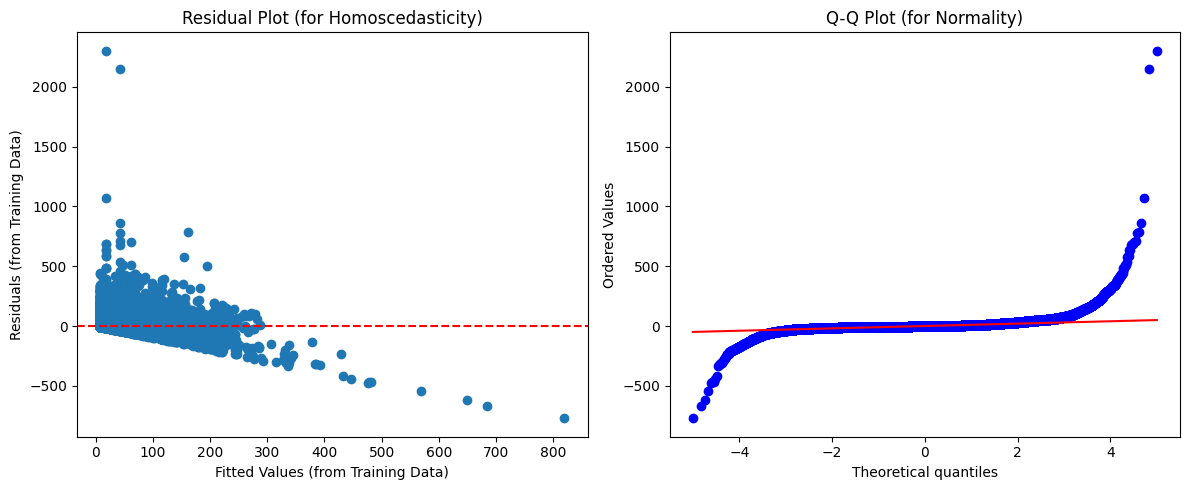

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                 6.228e+05
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:53:03   Log-Likelihood:            -9.5270e+06
No. Observations:             2444990   AIC:                         1.905e+07
Df Residuals:                 2444984   BIC:                         1.905e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  18.1374    

In [122]:
import matplotlib.pyplot as plt
import scipy.stats as stats

train_residuals = engineermodel.resid 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(engineermodel.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

print(engineermodel.summary())

## We Share — Reflection & Wrap‑Up

**Notes on Feature Selection**
- If **Engineered** doesn’t beat **Base** on TEST (or gains are tiny), prefer **Base** for simplicity.  
- If two engineered features are redundant (e.g., highly correlated dummies), consider dropping one.  
- Keep features that improve TEST error **and** you can explain to a stakeholder.


Write **2 short paragraphs** and be specific:


1) **Which model would you deploy today—Base or Engineered—and why?**  
Use **TEST MAE/RMSE in units**, your coefficient interpretations (baseline/interaction/polynomial), and any residual observations.

2) **What engineered feature was most useful (or not)?**  
Explain the **business logic** behind it and whether it earned its place on the TEST set. If not, what would you try next (different interaction, different categorical, or simplifying features)?